# <center> <h3> The code to generate Table 1  </h3> </center>
## <center> Ning Xu</center>


This file is compiled and generated automatically by Jupyter notebook. In this file, we demonstrate repeated simulations on the upper bound. The code in this file is almost the same as the supplementray file "CVbounds_markdown". In this file, given each value of $(n/K)/p$, we repeat the computation of the 90% upper bound on different i.i.d. samples 20 times. The results are attached below the codes.

## Step 1: define all the functions as we did in the file "CVbounds"

For more information, please see the file "CVbounds" or the simulation section in the paper.

## Jupyter notebook returns the results (figures, outcomes, prints) below the code box

In [1]:
# clear the memory before each compilation
%reset -f 

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from matplotlib.ticker import FuncFormatter

import pickle

In [2]:
#generate data for the regression

def data_gen(sample_size, n_dim, n_info, cov_noise):
    
    a = np.ones((n_dim, n_dim)) * 0.5; A = np.eye(n_dim)*0.5

    cov_x = a + A; mean_x = np.zeros(n_dim)

    X = np.random.multivariate_normal(mean_x, cov_x, sample_size)

    beta_info = np.arange(3,n_info + 3)
    beta = np.concatenate((beta_info, np.zeros(n_dim-n_info)), axis = 0)

    noise = np.random.normal(0, cov_noise, sample_size); 
    noise.shape = (sample_size, 1); beta.shape = (1, n_dim) 

    Y = np.inner(X,beta) + noise 

    return X, Y

In [3]:
# to estimate the Rademacher complexity, we generate rademacher variables 

def rade_generator( sample_size ):
    
    ans = np.random.randint(2, size=sample_size)
    rade = (ans - 0.5) * 2
    
    return rade


In [4]:
# estimating the empirical rademacher complexity

def emp_rc(sample_size, n_iter, reg, n_dim, n_info, cov_noise):
    
    X, Y = data_gen(sample_size, n_dim, n_info, cov_noise)
    
    cond = np.zeros([n_iter,1])
    
    for i in range(n_iter):
        
        rade = rade_generator(sample_size)
        reg.fit(X, rade) ; rade_pre = reg.predict(X)
        rade_pre = np.matrix(rade_pre); cond[i,0] = np.dot(rade_pre, rade)/ sample_size
    
    emp_rc = np.mean(cond) * 2 
   
    return emp_rc, cond


In [5]:
# estimating the rademacher complexity

def est_rc(sample_size, n_iter, reg, n_dim, n_info, cov_noise):
      
    cond_rc = np.zeros([n_iter])
    
    for i in range(n_iter):
        
        emp_rc_in, _ = emp_rc(sample_size, n_iter, reg, n_dim, n_info, cov_noise)

        cond_rc[i] = emp_rc_in

    est_rc = np.mean(cond_rc)
    
    return est_rc, cond_rc


In [6]:
# establishing the upper bound for classifiers

def rc_bound(n, M, varpi, K, rc_1, rc_2, ave_in_sample_error):
    
    ub = ave_in_sample_error + rc_1 + rc_2 + 2 * M * np.sqrt( np.log( 1 / varpi ) / ( n / K ) )
    
    return ub  


In [7]:
# compute the mean square error of the estimator

def costs(X_train, Y_train, clf):
    
    Y_pred_train = clf.predict(X_train); Y_pred_train.shape = Y_train.shape
    loss_train = mean_squared_error(Y_train, Y_pred_train)
    
    res = np.var(Y_train - Y_pred_train)
    
    return loss_train, res


In [8]:
# the function to estimate the upper bounds for the lasso

def error_bounds(X_train_1, Y_train_1, X_train_2, Y_train_2, 
              test_size, varpi, n_iter, n_val, n_dim, n_info, cov_noise, start, end, step):
    
    ##set the placeholders 
    alpha = np.arange(start, end, step)          # the seq of penalty parameters
    error_matrix = np.zeros((n_val, len(alpha))) # the n_val average test errors for each model
    upper_array  = np.zeros(len(alpha))          # the seq of 90 percentiles for all models 
    train_array  = np.zeros(len(alpha))          # the seq of average trainig errors for all models
    test_array   = np.zeros(len(alpha))          # the seq of CV-errors for all models
    perc_array   = np.zeros(len(alpha))
    
    for l in range(len(alpha)):
        
        #given the value of alpha
        
        #training classifiers
        clf  = Lasso(alpha = alpha[l])
        clf1 = Lasso(alpha = alpha[l]); clf1.fit(X_train_1, Y_train_1)
        clf2 = Lasso(alpha = alpha[l]); clf2.fit(X_train_2, Y_train_2)
        clf3 = Lasso(alpha = alpha[l]); clf2.fit(X_train_2, Y_train_2)
    
        #compute training errors
        loss_train_1, res_var_1 = costs(X_train_1, Y_train_1, clf1)
        loss_train_2, res_var_2 = costs(X_train_2, Y_train_2, clf2)
        train_array[l] = (loss_train_1 + loss_train_2)/2
        
        #compute test errors
        loss_test_1, res_var_3 = costs(X_train_2, Y_train_2, clf1)
        loss_test_2, res_var_4 = costs(X_train_1, Y_train_1, clf2)
        test_array[l] = (loss_test_1 + loss_test_2)/2
        
        res_var = max(res_var_3, res_var_4) ; M = res_var * 1.4
        

        #container of the validation errors
        error_val = np.zeros(n_val); 

        #the loop to compute the out-of-sample errors
        for i in range(n_val):

            X_val_1, Y_val_1 = data_gen(test_size, n_dim, n_info, cov_noise)
            X_val_2, Y_val_2 = data_gen(test_size, n_dim, n_info, cov_noise)

            Y_pred_val_1 = clf1.predict(X_val_1) ; loss_test_val_1 = mean_squared_error(Y_val_1 , Y_pred_val_1)
            Y_pred_val_2 = clf2.predict(X_val_2) ; loss_test_val_2 = mean_squared_error(Y_val_2 , Y_pred_val_2)

            error_val[i] = (loss_test_val_1 + loss_test_val_2)/2
        
        error_matrix[:,l] = error_val
        
        sorted_error = np.sort(error_val); perc_array[l] = sorted_error[-1*round(n_val*0.1)]

        # estimating the RC_test and RC_train
        est_rc_train, cond_rc_SVC_train = est_rc(test_size, n_iter, clf, n_dim, n_info, cov_noise)
        est_rc_test, cond_rc_SVC_test = est_rc(test_size, n_iter, clf, n_dim, n_info, cov_noise)

        #establish the upper bounds
        upper_array[l] = rc_bound( 2 * test_size, M, varpi, K, est_rc_train, est_rc_test, train_array[l])
        
    lambda_cv_ind  = np.argmin(test_array)
    lambda_cub_ind = np.argmin(upper_array)
    
    lambda_cv  = 1 + lambda_cv_ind  * 0.5
    lambda_cub = 1 + lambda_cub_ind * 0.5        
    
    return lambda_cv, lambda_cub

In [10]:
# the function to get the result of the variable/model selection

def lasso_norm(X12, Y12, X11, Y11, lambda_cv, lambda_cub):
    
    clf_11 = Lasso(alpha = lambda_cv ); clf_11.fit(X12, Y12)
    clf_12 = Lasso(alpha = lambda_cv ); clf_12.fit(X11, Y11)
    clf_21 = Lasso(alpha = lambda_cub); clf_21.fit(X12, Y12)
    clf_22 = Lasso(alpha = lambda_cub); clf_22.fit(X11, Y11)
    
    cub_selection_1 = np.nonzero(clf_21.sparse_coef_)[1] ; cub_norm_1 = np.linalg.norm(clf_21.coef_, ord=1)
    cub_selection_2 = np.nonzero(clf_22.sparse_coef_)[1] ; cub_norm_2 = np.linalg.norm(clf_22.coef_, ord=1)
    
    cv_selection_1  = np.nonzero(clf_11.sparse_coef_)[1] ; cv_norm_1  = np.linalg.norm(clf_11.coef_, ord=1)
    cv_selection_2  = np.nonzero(clf_12.sparse_coef_)[1] ; cv_norm_2  = np.linalg.norm(clf_12.coef_, ord=1)
    
    return cub_selection_1, cub_selection_2, cv_selection_1, cv_selection_2, cub_norm_1, cub_norm_2, cv_norm_1, cv_norm_2
    

In [6]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

## Step 2: the repeated simulation of the upper bounds for $n = 200$.

We repeat the $n=200$ simulation 20 times using different random seeds.

### In case that you don't want to run 10 hrs CPU computation, we attached "CVbounds_table.p" in the zip file. To load everything back, run the following codes

In [2]:
with open("CVbounds_table.p", "rb") as f:
    lambda_cv_seq       = pickle.load( f )
    lambda_cub_seq      = pickle.load( f )
    selection_cv_seq    = pickle.load( f )
    selection_cub_seq   = pickle.load( f )
    lambda_cv_seq_5     = pickle.load( f )
    lambda_cub_seq_5    = pickle.load( f )
    selection_cv_seq_5  = pickle.load( f )
    selection_cub_seq_5 = pickle.load( f )
    lambda_cv_seq_3     = pickle.load( f )
    lambda_cub_seq_3    = pickle.load( f )
    selection_cv_seq_3  = pickle.load( f )
    selection_cub_seq_3 = pickle.load( f )

### Or you can redo the computation

In [ ]:
## average test error bounds for the lasso
## total sample size : 200

n2 = 100; test_size = n2;  #n2 is the size of each fold

# generate data

varpi = 0.1; K = 2

n_iter = 64; n_val = 10000; n_dim = 100; n_info = 5; cov_noise = 1

start = 0.1; end = 0.5; step = 0.05; alpha = np.arange(start, end, step)

end_seed = 300; step_seed = 5

lambda_cv_seq = list(); lambda_cub_seq = list()
selection_cv_seq = list();selection_cub_seq = list()

for i in range(0, end_seed, step_seed):
    
    np.random.seed(i)

    X12, Y12 = data_gen(n2, n_dim, n_info, cov_noise)

    X22, Y22 = data_gen(n2, n_dim, n_info, cov_noise)


    # training the model
    lambda_cv, lambda_cub = error_bounds(X12, Y12, X22, Y22, test_size, varpi, n_iter, n_val, n_dim, n_info, cov_noise, start, end, step)

    cub_selection_1, cub_selection_2, cv_selection_1, cv_selection_2, cub_norm_1, cub_norm_2, cv_norm_1, cv_norm_2 = lasso_norm(X12, Y12, X22, Y22, lambda_cv, lambda_cub)
    
    selection_cub_seq.append(cub_selection_1); selection_cub_seq.append(cub_selection_2)
    selection_cv_seq.append(cv_selection_1); selection_cv_seq.append(cv_selection_2)
    
    lambda_cub_seq.append(cub_norm_1); lambda_cub_seq.append(cub_norm_2)
    lambda_cv_seq.append(cv_norm_1); lambda_cv_seq.append(cv_norm_2)

### You can continue the plotting if you load  "CVbounds_table.p" or finished the computation.

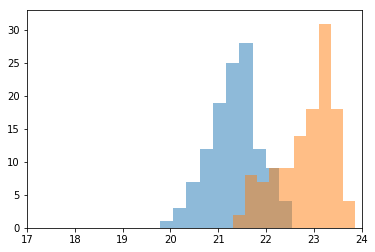

In [18]:
f1 = plt.figure()
plt.hist(lambda_cub_seq,alpha=0.5, label='the $L_1$ norm of the lasso based on $\lambda_{cub}$')
plt.hist(lambda_cv_seq, alpha=0.5, label='the $L_1$ norm of the lasso based on $\lambda_{CV}$')
#pyplot.legend(loc=0)
plt.xlim(17, 24)
plt.ylim(0, 33)

plt.show()

f1.savefig("n=200.pdf", bbox_inches='tight')

In [11]:
num_variable_cv  = list(); ind_variable_cv  = 0
num_variable_cub = list(); ind_variable_cub = 0

for i in range(len(selection_cub_seq)):
    
    item_cub = selection_cub_seq[i]; item_cv = selection_cv_seq[i]
    num_variable_cub.append(len(item_cub)); num_variable_cv.append(len(item_cv))
    
    if (all(x in item_cub for x in [0, 1, 2, 3, 4]) == True):
        
        ind_variable_cub += 1
    
    if (all(x in item_cv for x in [0, 1, 2, 3, 4]) == True):
        
        ind_variable_cv  += 1

print("on average CV select",np.mean(num_variable_cv),"variables")

if (ind_variable_cv >= 0.9 * len(selection_cub_seq)):
    print("in all 40 simulations of CV, 90% of 40 select the first 5 variables")
    
print("on average minimizing the upper bounds select",np.mean(num_variable_cub),"variables")

if (ind_variable_cub >= 0.9 * len(selection_cub_seq)):
    print("in all 40 simulations of CUB, 90% of 40 select the first 5 variables")

on average CV select 9.0 variables
in all 40 simulations of CV, 90% of 40 select the first 5 variables
on average minimizing the upper bounds select 8.125 variables
in all 40 simulations of CUB, 90% of 40 select the first 5 variables


In [14]:
print("the variance of the number of the variable selected by CV is",np.var(num_variable_cv))
print("the variance of the number of the variable selected by CUB is",np.var(num_variable_cub))

the variance of the number of the variable selected by CV is 5.6
the variance of the number of the variable selected by CUB is 4.592708333333333


## Step 3: the repeated simulation of the upper bounds for $n = 400$.

We repeat the $n=400$ simulation 20 times using different random seeds. All the plots are attached after the code.


### You can skip the following computation if you already load  "CVbounds_table.p"

In [ ]:
## average test error bounds for the lasso
## total sample size : 400

n5 = 200; test_size_5 = n5; np.random.seed(50) #n4 is the size of each fold

# generate data

lambda_cv_seq_5 = list(); lambda_cub_seq_5 = list()
selection_cv_seq_5 = list();selection_cub_seq_5 = list()

for i in range(0, end_seed, step_seed):
    
    np.random.seed(i)

    X15, Y15 = data_gen(n5, n_dim, n_info, cov_noise)

    X25, Y25 = data_gen(n5, n_dim, n_info, cov_noise)

    # training the model
    
    lambda_cv_5, lambda_cub_5 = error_bounds(X15, Y15, X25, Y25, test_size_5, varpi, n_iter, n_val, n_dim, n_info, cov_noise, start, end, step)

    cub_selection5_1, cub_selection5_2, cv_selection5_1, cv_selection5_2, cub_norm5_1, cub_norm5_2, cv_norm5_1, cv_norm5_2 = lasso_norm(X15, Y15, X25, Y25, lambda_cv_5, lambda_cub_5)
    
    selection_cub_seq_5.append(cub_selection5_1); selection_cub_seq_5.append(cub_selection5_2)
    selection_cv_seq_5.append(cv_selection5_1); selection_cv_seq_5.append(cv_selection5_2)
    
    lambda_cub_seq_5.append(cub_norm5_1); lambda_cub_seq_5.append(cub_norm5_2)
    lambda_cv_seq_5.append(cv_norm5_1); lambda_cv_seq_5.append(cv_norm5_2)

### the plotting function

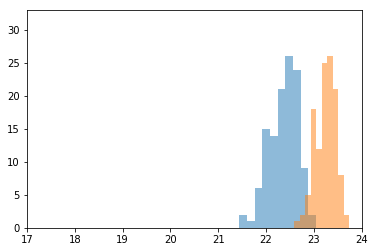

In [17]:
f5 = plt.figure()
plt.hist(lambda_cub_seq_5,alpha=0.5, label='the $L_1$ norm of the lasso based on $\lambda_{cub}$')
plt.hist(lambda_cv_seq_5, alpha=0.5, label='the $L_1$ norm of the lasso based on $\lambda_{CV}$')
#plt.legend(loc=0)
plt.xlim(17, 24)
plt.ylim(0, 33)

plt.show()

f5.savefig("n=400.pdf", bbox_inches='tight')

In [7]:
num_variable_cv_5  = list(); ind_variable_cv_5  = 0
num_variable_cub_5 = list(); ind_variable_cub_5 = 0

for i in range(len(selection_cub_seq)):
    
    item_cub = selection_cub_seq_5[i]; item_cv = selection_cv_seq_5[i]
    num_variable_cub_5.append(len(item_cub)); num_variable_cv_5.append(len(item_cv))
    
    if (all(x in item_cub for x in [0, 1, 2, 3, 4]) == True):
        
        ind_variable_cub_5 += 1
    
    if (all(x in item_cv for x in [0, 1, 2, 3, 4]) == True):
        
        ind_variable_cv_5  += 1


print("on average CV select",np.mean(num_variable_cv_5),"variables")
if (ind_variable_cv_5 >= 0.9 * len(selection_cub_seq_5)):
    print("in all 40 simulations of CV, 90% of 40 select the first 5 variables")
    
print("on average minimizing the upper bounds select",np.mean(num_variable_cub_5),"variables")
if (ind_variable_cub_5 >= 0.9 * len(selection_cub_seq_5)):
    print("in all 40 simulations of CUB, 90% of 40 select the first 5 variables")

on average CV select 6.758333333333334 variables
in all 40 simulations of CV, 90% of 40 select the first 5 variables
on average minimizing the upper bounds select 6.116666666666666 variables
in all 40 simulations of CUB, 90% of 40 select the first 5 variables


In [18]:
print("the variance of the number of the variable selected by CV is",np.var(num_variable_cv_5))
print("the variance of the number of the variable selected by CUB is",np.var(num_variable_cub_5))

the variance of the number of the variable selected by CV is 2.5499305555555556
the variance of the number of the variable selected by CUB is 1.286388888888889


## Step 4 the repeated simulation of the upper bounds for $n = 100$.


Finally we repeat the $n=100$ simulation 20 times using different random seeds. All the plots are attached after the code.


### You can skip the following computation if you already load  "CVbounds_table.p"

In [ ]:
## average test error bounds for the lasso
## total sample size : 100

n3 = 50; test_size_3 = n3; np.random.seed(50) #n3 is the size of each fold

# generate data

lambda_cv_seq_3 = list(); lambda_cub_seq_3 = list()
selection_cv_seq_3 = list();selection_cub_seq_3 = list()

for i in range(0, end_seed, step_seed):
    
    np.random.seed(i)

    X13, Y13 = data_gen(n3, n_dim, n_info, cov_noise)

    X23, Y23 = data_gen(n3, n_dim, n_info, cov_noise)

    # training the model
    
    lambda_cv_3, lambda_cub_3 = error_bounds(X13, Y13, X23, Y23, test_size_3, varpi, n_iter, n_val, n_dim, n_info, cov_noise, start, end, step)

    cub_selection3_1, cub_selection3_2, cv_selection3_1, cv_selection3_2, cub_norm3_1, cub_norm3_2, cv_norm3_1, cv_norm3_2 = lasso_norm(X13, Y13, X23, Y23, lambda_cv_3, lambda_cub_3)
    
    selection_cub_seq_3.append(cub_selection3_1); selection_cub_seq_3.append(cub_selection3_2)
    selection_cv_seq_3.append(cv_selection3_1); selection_cv_seq_3.append(cv_selection3_2)
    
    lambda_cub_seq_3.append(cub_norm3_1); lambda_cub_seq_3.append(cub_norm3_2)
    lambda_cv_seq_3.append(cv_norm3_1); lambda_cv_seq_3.append(cv_norm3_2)

### the plotting function

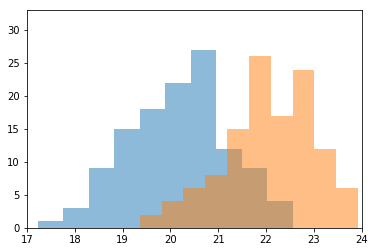

In [16]:
f3 = plt.figure()
plt.hist(lambda_cub_seq_3,alpha=0.5, label='the $L_1$ norm of the lasso based on $\lambda_{cub}$')
plt.hist(lambda_cv_seq_3, alpha=0.5, label='the $L_1$ norm of the lasso based on $\lambda_{CV}$')
#pt.legend(loc=0)
plt.xlim(17, 24)
plt.ylim(0, 33)

plt.show()

f3.savefig("n=100.pdf", bbox_inches='tight')

In [5]:
num_variable_cv_3  = list(); ind_variable_cv_3  = 0
num_variable_cub_3 = list(); ind_variable_cub_3 = 0

for i in range(len(selection_cub_seq_3)):
    
    item_cub = selection_cub_seq_3[i]; item_cv = selection_cv_seq_3[i]
    num_variable_cub_3.append(len(item_cub)); num_variable_cv_3.append(len(item_cv))
    
    if (all(x in item_cub for x in [0, 1, 2, 3, 4]) == True):
        
        ind_variable_cub_3 += 1
    
    if (all(x in item_cv for x in [0, 1, 2, 3, 4]) == True):
        
        ind_variable_cv_3  += 1

print("on average CV select",np.mean(num_variable_cv_3),"variables")
if (ind_variable_cv_3 >= 0.9 * len(selection_cub_seq_3)):
    print("in all 40 simulations of CV, 90% of 40 select the first 5 variables")
    
print("on average minimizing the upper bounds select",np.mean(num_variable_cub_3),"variables")
if (ind_variable_cub_3 >= 0.9 * len(selection_cub_seq_3)):
    print("in all 40 simulations of CUB, 90% of 40 select the first 5 variables")

on average CV select 11.591666666666667 variables
in all 40 simulations of CV, 90% of 40 select the first 5 variables
on average minimizing the upper bounds select 11.166666666666666 variables
in all 40 simulations of CUB, 90% of 40 select the first 5 variables


In [22]:
print("the variance of the number of the variable selected by CV is",np.var(num_variable_cv_3))
print("the variance of the number of the variable selected by CUB is",np.var(num_variable_cub_3))

the variance of the number of the variable selected by CV is 10.441597222222223
the variance of the number of the variable selected by CUB is 9.488888888888887


## last step: save everything into a pickle file

In [33]:
with open("CVbounds_table.p", "wb") as f:
    pickle.dump( lambda_cv_seq, f)
    pickle.dump( lambda_cub_seq, f)
    pickle.dump( selection_cv_seq, f)
    pickle.dump( selection_cub_seq, f)
    
    pickle.dump( lambda_cv_seq_5 , f)
    pickle.dump( lambda_cub_seq_5 , f)
    pickle.dump( selection_cv_seq_5 , f)
    pickle.dump( selection_cub_seq_5 , f)
    
    pickle.dump( lambda_cv_seq_3 , f)
    pickle.dump( lambda_cub_seq_3 , f)
    pickle.dump( selection_cv_seq_3 , f)
    pickle.dump( selection_cub_seq_3 , f)